Put selling is often framed as a strategy where you can set a future purchase price for a stock you like, and get paid a premium as you wait for the stock to pull back to the target price.
I see this as an oversimplification, and hope to make that clear with a simplified example.

I will compare the out-of-the-money (otm) put sale to another strategy that would accomplish the same stated goal, a dip-buying startegy where we sit in cash until the stock falls to or below the target price. We will see that the put sale, while it leads to lower volatility than the dip buying strategy, the characteristics of the returns are very different. Namely, upside is very limited but downside is not (highly negative skew).  It will be up to the reader to decide if the premium collected is adequate compensation for this negative skewness. But what will hopefully be clear is that put selling is NOT dip buying + a premium.

In the first code cell, we import some libraries ("imports" is a wrapper that pulls in a library I built called blackscholes that calculates option values)

In [1]:
import blackscholes as bsm
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.style as stl
stl.use('ggplot')
%matplotlib inline

In the cell below, we start by building a monte carlo function to run paths of geometric brownian motion.  This is an oversimplified model for a stock price, but can still give us some insight into the differences of the two strategies

In [2]:
def gbm(r=0, v=0.3, T=5, S0=100, M=60, I=5):
    dt = T / M
    S = np.zeros((M + 1, I)) #each column is a path of M returns
    S[0] = S0
    for t in range (1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * v**2) * dt + v * np.sqrt(dt) * npr.standard_normal(I)) #every loop simulates an individual period I times
    return S

In [3]:
#gbm inputs
r = 0 #drift (zero for simplicity)
v = 0.3 #constant volatility
T = 1 #simulation time in years
S0 = 100 #starting stock price
M = 52 #periods in within T. M=52 with T=1 implies weekly returns
I = 10000 #number of simulations in the monte carlo

#we will call the stock price paths S
S = gbm(r=r, v=v, T=T, S0=S0, M=M, I=I)
S.shape #each row is a period, each column is a simulated path.  there are M+1 rows because we start at S0 for all paths

(53, 10000)

We're going to use the matrix S as the stock price paths to build paths for the put selling and dip buying strategies. To confirm everything works, we plot a histogram to verify we have a lognormal dist

(array([  5.,   5.,  49., 115., 231., 371., 485., 752., 731., 839., 852.,
        767., 736., 678., 587., 514., 461., 356., 302., 233., 191., 151.,
        139., 114.,  86.,  57.,  48.,  30.,  25.,  21.,  14.,  13.,   8.,
          9.,   5.,   3.,   4.,   3.,   2.,   0.,   2.,   0.,   0.,   2.,
          0.,   1.,   0.,   1.,   0.,   2.]),
 array([ 28.13000069,  33.84887251,  39.56774434,  45.28661616,
         51.00548798,  56.7243598 ,  62.44323163,  68.16210345,
         73.88097527,  79.5998471 ,  85.31871892,  91.03759074,
         96.75646256, 102.47533439, 108.19420621, 113.91307803,
        119.63194986, 125.35082168, 131.0696935 , 136.78856532,
        142.50743715, 148.22630897, 153.94518079, 159.66405262,
        165.38292444, 171.10179626, 176.82066808, 182.53953991,
        188.25841173, 193.97728355, 199.69615538, 205.4150272 ,
        211.13389902, 216.85277085, 222.57164267, 228.29051449,
        234.00938631, 239.72825814, 245.44712996, 251.16600178,
        256.884873

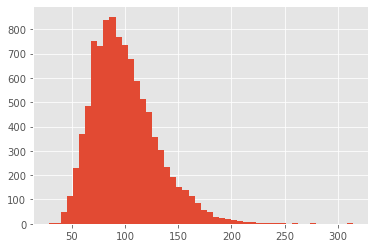

In [4]:
plt.hist(S[-1],bins=50)

Here we will build the matrix of put values, essentially repricing the put option for each stock price in each path

In [5]:
def put_selling_strategy(S, div, rf_rate, iv, spot, time, strike):
    P = np.zeros(S.shape) #same dimensions as the stock paths
    P0 = bsm.option(opt_type=opt_type, div_yield=div, rf_rate=r, volatility=iv, spot=spot, time=t, strike=strike).value()
    P[0] = P0 * -1 + strike + P0 #hold cash equal to strike, sell put and collect premium cash
    print(P0)
    dt = t / M
    tau = t - dt #tau will be the time remaining until expiration, it will increment lower for each period. We already valued the option at time 0 where tau = t, the first simulated row will use t -  dt
    for i in range(1, S.shape[0]):
        for j in range(S.shape[1]):
            if tau <= 0:
                P[i, j] = strike + P0 + max(0, strike - S[i , j]) * -1
            else:
                put = bsm.option(opt_type=opt_type, div_yield=div, rf_rate=r, volatility=iv, spot=S[i,j], time=tau, strike=strike)
                P[i,j] = put.value() * -1 + P0 + strike #every point will be the starting cash plus the (negative) put value
        tau -= dt
    #P = P + strike + P0 #to transform from put pos values to strat values, add collateral cash & initial premium received
    return P

In [6]:
#option inputs
opt_type = 'put'
spot = S0
div = 0
rf_rate = r
iv = 0.3 #first, we'll assume the option is fairly priced at the true volatility of the stock, which, in practice, cannot be known in advance
t = 1
strike = 80 #this is the level we would like to buy the stock, analogous to the target price in the dip buying strategy
P0 = bsm.option(opt_type, div, rf_rate, iv, spot, t, strike).value()
P0

3.534390103173756

In [7]:
%time P = put_selling_strategy(S, div, rf_rate, iv, spot, t, strike)


3.534390103173756
Wall time: 28min 15s


In [8]:
np.mean(P[-1]-P[0])

-0.034711096136336

Next, we build the dip buying strategy (matrix D). It will buy one share of stock if the price of the stock falls below the target price. We will assume the price is continuous, and the buy price is always the target price.

To build the paths for this strategy, we'll start with an amount of cash equal to the target price. If the stock never hits the target, strategy stays in cash. If it does, we assume the stock was bought for the target price. Again, we assume the price movement was continuous and we bought as soon as the stock touched the target (from a practical standpoint, this assumption should penalize the dip buying strategy relative to reality, because if the stock has gaps, you might buy below the target price)

In [9]:
def dip_buying_strategy(S, tgt):
    D = np.zeros(S.shape)
    D_active = np.zeros(S.shape)#this will be a boolean matrix that tells us whether or not the strategy is invested in each path
    D[0] = tgt

    for i in range(1, S.shape[0]):
        for j in range(S.shape[1]):
            if D_active[i, j] == 1:
                continue 
            elif S[i, j] <= tgt:
                D_active[i:, j] = 1
                D[i, j] = tgt
                D[i+1: , j] = S[i+1: , j] #once we know the strategy is invested, it will just take the value of S for the rest of that column           
            else:
                D[i,j] = D[i-1,j]
    return D

In [10]:
tgt = strike
D = dip_buying_strategy(S, tgt)

Now that we have our paths, we can start making some comparisons. First, we will rescale the put selling strategy by assuming we started with the same amount of cash as the dip buying strategy. We'll also account for the cash collected from the put sale, making the initial trade have no impact on the position value, as it should be. With both strategies using the same base, we can compare average returns and volatility

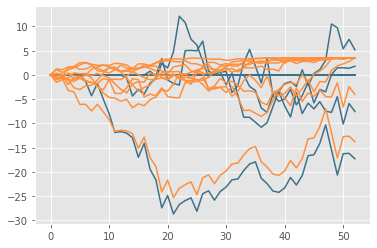

In [11]:
#plot ten paths for each strategy
dark_blue = [62/255,112/255,137/255]
orange = [255/255, 143/255, 59/255]
plt.plot(D[:,10:20]-D[0,0], color=dark_blue)
plt.plot(P[:,10:20]-P[0,0], color=orange)

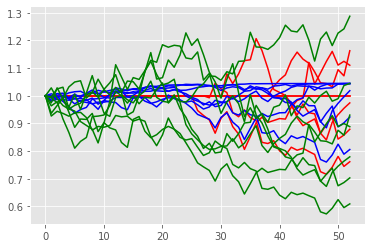

In [12]:
plt.plot(D[:,:7]/D[0,0], color='red')
plt.plot(P[:,:7]/P[0,0], color='blue')
plt.plot(S[:,:7]/S[0,0], color='green')

In [20]:
import pandas as pd
#looking at the dispersion of terminal values
S_terminal = pd.Series(S[-1]/S[0]-1)
D_terminal = pd.Series(D[-1]/D[0]-1)
P_terminal = pd.Series(P[-1]/P[0]-1)
print("Buy and hold")
print(S_terminal.describe())
print("\nBuy the dip")
print(D_terminal.describe())
print("\nSell OTM put")
print(P_terminal.describe())

Buy and hold
count    10000.000000
mean         0.000974
std          0.309678
min         -0.706829
25%         -0.218680
50%         -0.048670
75%          0.171722
max          2.242549
dtype: float64

Buy the dip
count    10000.000000
mean        -0.010816
std          0.151869
min         -0.633536
25%         -0.021904
50%          0.000000
75%          0.000000
max          1.227291
dtype: float64

Sell OTM put
count    10000.000000
mean        -0.000071
std          0.094475
min         -0.589356
25%          0.020829
50%          0.044180
75%          0.044180
max          0.044180
dtype: float64


Since the process has zero drift, and the put is priced at true volatility, all 3 strategies have an expected return of 0. The putwrite comes in with the lowest standard deviation, suggesting that it has the lowest risk, but notice the max return is truncated and losses are not. The risk in the putwrite is the negative skew. 

Boxplots can illustrate this difference.  We plot the terminal value of each strategy relative to the starting value, while excluding the paths of the dip buying strategies where we never actually invest. You can see the put sale has a higher median, but is very negatively skewed.

{'whiskers': [<matplotlib.lines.Line2D at 0x1865fafee20>,
 'caps': [<matplotlib.lines.Line2D at 0x1865fb0d520>,
 'boxes': [<matplotlib.lines.Line2D at 0x1865fafeac0>,
 'medians': [<matplotlib.lines.Line2D at 0x1865fb0dc10>,
 'fliers': [<matplotlib.lines.Line2D at 0x1865fb0df70>,
 'means': []}

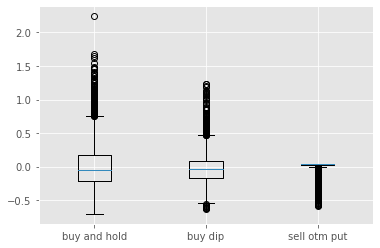

In [21]:
#plt.boxplot(x=[S[-1], D[-1], P[-1]], labels=['buy and hold','buy dip','sell otm put'])
plt.boxplot(x=[S_terminal,D_terminal[D_terminal!=0], P_terminal], labels=['buy and hold','buy dip','sell otm put'])

#plt.ylim([-0.05,0.05])

In [22]:
print(f'''               SKEW OF TERMINAL VALUES
            Buy and hold: {S_terminal.skew()}.
            Buy the dip: {D_terminal.skew()}
            Sell OTM put: {P_terminal.skew()}
            ''')

               SKEW OF TERMINAL VALUES
            Buy and hold: 0.9372279295853045.
            Buy the dip: 1.2522314606008604
            Sell OTM put: -2.451050429074009
            


To recap, we've seen that, when the put option is fairly priced (implied volatility matches true volatility of the underlying), the put writing strategy has an expected return of 0, with a positive median return, and is very negatively skewed. This is very different from the dip buying strategy which is just a lower volatility version of buy and hold

Now, assume the option was trading at an implied volatility of 0.4

In [23]:
P_posVRP = put_selling_strategy(S,div, rf_rate, 0.4, spot, t, strike)

6.391183524514435


In [24]:
P_posVRP_t = P_posVRP[-1]/P_posVRP[0] - 1

In [25]:
P_negVRP = put_selling_strategy(S, div, rf_rate, 0.2, spot, t, strike)

1.1859295132104322


In [26]:
P_negVRP_t = P_negVRP[-1]/P_negVRP[0] - 1

Text(0.5, 1.0, 'Simulated Returns')

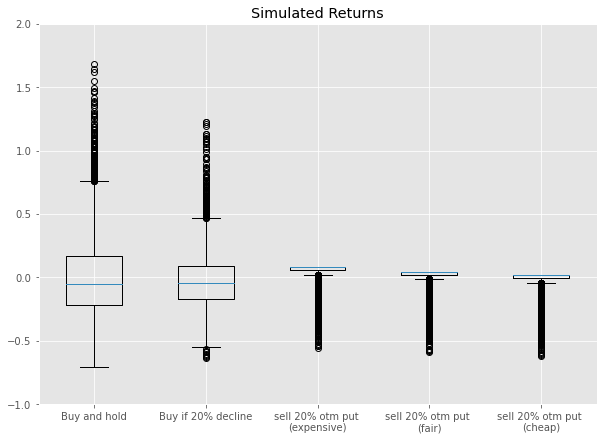

In [51]:
fig = plt.figure(figsize=(10,7))
plt.boxplot(x=[S_terminal,D_terminal[D_terminal!=0], P_posVRP_t, P_terminal, P_negVRP_t], labels=['Buy and hold','Buy if 20% decline','sell 20% otm put \n(expensive)', 'sell 20% otm put \n(fair)', 'sell 20% otm put \n(cheap)'], whis=1.5)
plt.ylim((-1,2))
plt.title('Simulated Returns')


In [47]:
terminal_values = pd.DataFrame({'Buy and hold':S_terminal, 'Buy if 20% decline':D_terminal, 'Sell 20% otm put (high vol)': P_posVRP_t,
             'Sell 20% otm put (fair vol)': P_terminal, 'Sell 20% otm put (low vol)': P_negVRP_t})
terminal_values.describe()


,Buy and hold,Buy if 20% decline,Sell 20% otm put (high vol),Sell 20% otm put (fair vol),Sell 20% otm put (low vol)
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.000974,-0.010816,0.035639,-0.000071,-0.029427
std,0.309678,0.151869,0.094475,0.094475,0.094475
min,-0.706829,-0.633536,-0.553647,-0.589356,-0.618712
25%,-0.218680,-0.021904,0.056539,0.020829,-0.008526
50%,-0.048670,0.000000,0.079890,0.044180,0.014824
75%,0.171722,0.000000,0.079890,0.044180,0.014824
max,2.242549,1.227291,0.079890,0.044180,0.014824


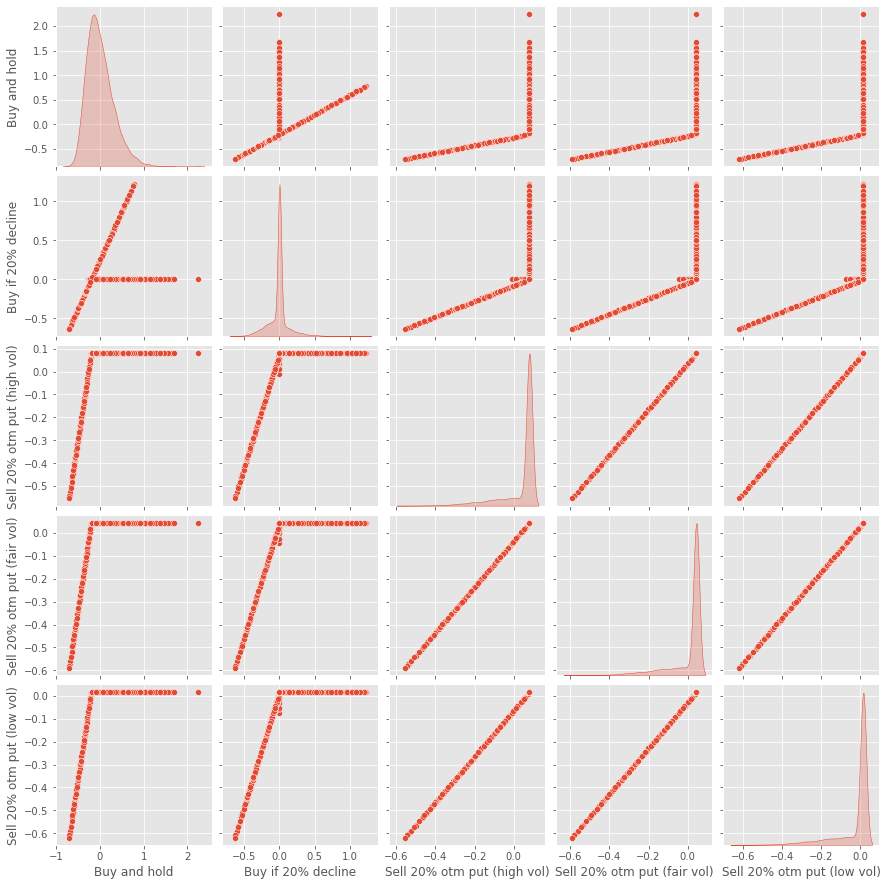

In [50]:
import seaborn as sns
sns.pairplot(data=terminal_values, diag_kind='kde', corner=False)

We now see that, selling otm puts is not "another way to buy the dip" it is a fundamentally different trade.  It may well be better than buying the dip, but the question is to weigh the premium received against the negative skew of the return distribution. We see importantly that the price you get for the put matters, if the premium is underpriced (implied vol less than true vol), the put strategy has negative expected return on top of the negative skew. It also worth noting that this has assumed zero drift for the underlying, if there is an equity risk premium of some kind in the realized equity returns, the expected returns of the buy and hold and dip buying strategies will catch up to put selling.



In [28]:
summary_df = pd.DataFrame({
                          'buy and hold': [np.mean(S_terminal), np.std(S_terminal),  np.max(S_terminal), np.min(S_terminal)],
                          'buy dip': [np.mean(D_terminal), np.std(D_terminal),  np.max(D_terminal), np.min(D_terminal)],
                          'sell otm put (expensive)': [np.mean(P_posVRP_t), np.std(P_posVRP_t), np.max(P_posVRP_t), np.min(P_posVRP_t)],
                          'sell otm put (fair)': [np.mean(P_terminal), np.std(P_terminal), np.max(P_terminal), np.min(P_terminal)],
                          'sell otm put (cheap)': [np.mean(P_negVRP_t), np.std(P_negVRP_t), np.max(P_negVRP_t), np.min(P_negVRP_t)]
                          }
                            ,index=['mean', 'stdev', 'max', 'min'])
summary_df

,buy and hold,buy dip,sell otm put (expensive),sell otm put (fair),sell otm put (cheap)
mean,0.000974,-0.010816,0.035639,-0.000071,-0.029427
stdev,0.309663,0.151862,0.094470,0.094470,0.094470
max,2.242549,1.227291,0.079890,0.044180,0.014824
min,-0.706829,-0.633536,-0.553647,-0.589356,-0.618712


The takeaway is, if you think the otm put is expensive, sell it (maybe with a furtehr otm put hedge to avoid the really ugly scenarios). But if you don't know if the puts are expensive, fair or undervalued, you're better off with the dip buying strategy.

We can never know if we're going to be right about any trade, but it is important to be clear-headed about our actual thesis, because if our asessment is correct, we want to make sure the instrument we use to express the view is most appropriate.  This brings us to the next part of this analysis.  The underlying equity distribution.  It seems that, if we are interested in some kind of dip buying strategy, it is because we think that, if there is a pullback, there will be at least some mean reversion afterward, which we will capture buy buying the dip when the market overshoots. If there is not mean reversion, and the underlying process is more like a geometric brownian motion, then we can see with the statistics above that we could get roughly the same outcome as the dip buying strategy by simply buying the stock with a reduced position size.

We can rerun the monte carlo, assuming the underlying stock follows a square root diffusion process, with the long run value being somewhere between the current price and the target price (we'll use the half way point)

In [29]:
#TODO square root diffusion process
kappa = 1/3 #mean reversion speed factor
theta = (S0 + tgt) / 2

def sq_rt_diffusion(S0, kappa, theta, volatility, T=1, M=52, I=10000):
    dt = T / M
    X = np.zeros((M + 1, I))
    X1 = np.zeros_like(X)
    X[0] = S0
    X1[0] = S0
    for t in range(1, M + 1):
        X[t] = X[t - 1] + kappa * (theta - np.maximum(X[t - 1], 0)) * dt + volatility * np.sqrt(np.maximum(X[t - 1], 0)) * np.sqrt(dt) * npr.standard_normal(I)
    X1 = np.maximum(X, 0)
    return X1

In [30]:
X = sq_rt_diffusion(S0=S0, kappa=kappa, theta=90, volatility=0.4, T=3, M=52, I=10000)

(array([0.00014127, 0.        , 0.        , 0.00014127, 0.00028254,
        0.00042381, 0.00070635, 0.00127144, 0.00183652, 0.00211906,
        0.00466194, 0.00776989, 0.00875879, 0.01313818, 0.02048426,
        0.02260333, 0.03348118, 0.03899074, 0.05015113, 0.06032263,
        0.06540837, 0.07035285, 0.0856101 , 0.08772916, 0.09083712,
        0.0890006 , 0.08546883, 0.08151324, 0.07317827, 0.07120048,
        0.06272423, 0.05905119, 0.04774953, 0.0367304 , 0.03616532,
        0.0227446 , 0.02006045, 0.01539852, 0.0125731 , 0.01229056,
        0.00607464, 0.00395558, 0.00254287, 0.00155398, 0.00127144,
        0.00183652, 0.00141271, 0.00042381, 0.        , 0.00056508]),
 array([ 75.55676457,  76.26462501,  76.97248544,  77.68034587,
         78.3882063 ,  79.09606673,  79.80392717,  80.5117876 ,
         81.21964803,  81.92750846,  82.63536889,  83.34322932,
         84.05108976,  84.75895019,  85.46681062,  86.17467105,
         86.88253148,  87.59039192,  88.29825235,  89.00611278

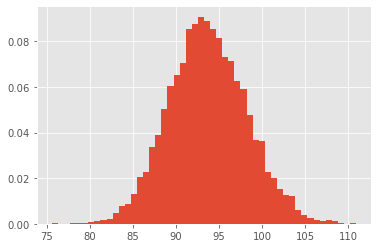

In [31]:
plt.hist(X[-1], bins=50, density=True)

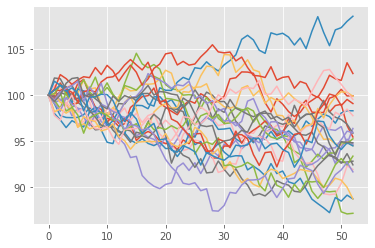

In [32]:
plt.plot(X[:,:25])

In [33]:
min_per_path = [np.min(path) for path in X.T]
np.min(min_per_path)

75.55676457413153

In [34]:
D_meanrev = dip_buying_strategy(X, 85)


In [35]:
D_meanrev_active = np.array([path for path in D_meanrev.T if np.std(path) != 0]).T
D_meanrev_active.shape[1] / D_meanrev.shape[1]

0.0463

(array([  1.,   5.,  20.,  79., 158., 120.,  48.,  23.,   5.,   4.]),
 array([75.55676457, 77.59122084, 79.6256771 , 81.66013336, 83.69458962,
        85.72904588, 87.76350214, 89.7979584 , 91.83241466, 93.86687093,
        95.90132719]),
 <BarContainer object of 10 artists>)

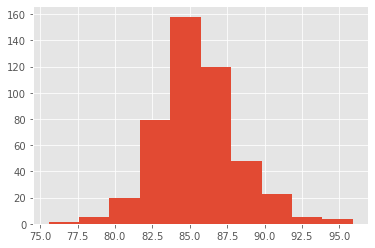

In [36]:
plt.hist(D_meanrev_active[-1])

In [37]:
np.mean(D_meanrev_active[-1] / D_meanrev_active[0] - 1)

0.006608929729527959

In [38]:
P_meanrev = put_selling_strategy(X, 0, 0, 0.4, 100, 1, 80)

6.391183524514435


In [39]:
np.mean(P_meanrev[-1])

86.39015687570091

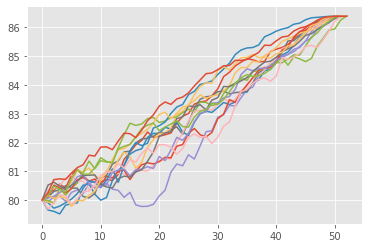

In [40]:
plt.plot(P_meanrev[:,:15])

In [41]:
X_terminal = (X[-1] / X[0]) - 1
D_meanrev_terminal = (D_meanrev[-1] / D_meanrev[0]) - 1
P_meanrev_terminal = (P_meanrev[-1] / P_meanrev[0]) - 1

{'whiskers': [<matplotlib.lines.Line2D at 0x18662e2b100>,
 'caps': [<matplotlib.lines.Line2D at 0x18662e2b7c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x18662e1cd60>,
 'medians': [<matplotlib.lines.Line2D at 0x18662e2be80>,
 'fliers': [<matplotlib.lines.Line2D at 0x18662e35220>,
 'means': []}

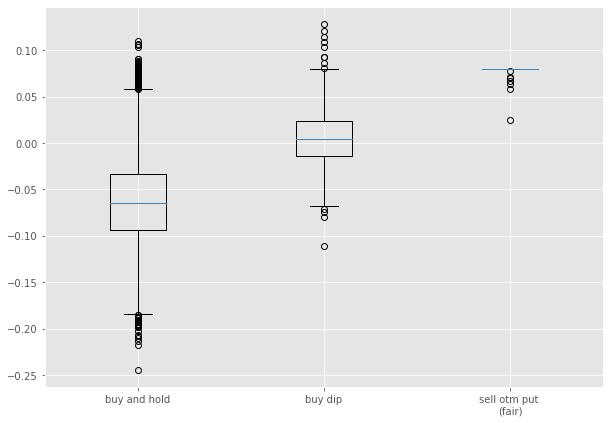

In [42]:
fig = plt.figure(figsize=(10,7))
#plt.boxplot(x=[X_terminal,D_meanrev_terminal, P_meanrev_terminal], labels=['buy and hold','buy dip','sell otm put \n(fair)'], whis=1.5)
plt.boxplot(x=[X_terminal,D_meanrev_terminal[D_meanrev_terminal!=0], P_meanrev_terminal], labels=['buy and hold','buy dip','sell otm put \n(fair)'], whis=1.5)
#plt.ylim((-1,1))